# ![VGG16 Gradcam - LIME - SHAP](https://miro.medium.com/v2/resize:fit:1400/0*WiQyXNkLZsT6P1Zf.png)

#IMPORT E SETUP

In [ ]:
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from google.colab import drive
import os
from keras.callbacks import ModelCheckpoint
!pip install -q -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

# Collegare Google Drive
drive.mount('/content/drive', force_remount=True)

# Creare una cartella chiamata 'AAoMC' su Google Drive per salvare i dati
base_path = "/content/drive/My Drive/AAoMC"
if not os.path.exists(base_path):
    os.makedirs(base_path)


Mounted at /content/drive


#DATASET PREPROCESSING

In [ ]:
import zipfile
import os


zip_file_path = os.path.join(base_path, 'archive_test.zip')  # Nome del file zip
extract_path = '/content/estrazione/'  # Percorso di estrazione

# Estrai l'archivio zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Definisci i nuovi percorsi dopo l'estrazione
file_path = os.path.join(extract_path, 'dataset.txt')
images_path = os.path.join(extract_path, 'dataset')

In [ ]:
import pandas as pd
import os


# Funzione per leggere il file di testo e generare i percorsi e le etichette
def process_file(file_path, images_path):
    paths = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 3:  # Verifica che ci siano almeno 3 parole
                image_file_name = parts[-3]  # Nome del file
                label = parts[-2]  # Etichetta

                # Costruisci il percorso completo dell'immagine
                image_path = os.path.join(images_path, image_file_name)

                # Aggiungi i dati alle liste
                paths.append(image_path)
                labels.append(label)

    return paths, labels

# Esegui la funzione
paths, labels = process_file(file_path, images_path)

# Crea il DataFrame
dataframe = pd.DataFrame({
    'file': paths,
    'label': labels
})

# Mostra le prime righe del DataFrame
print(dataframe.head())


                                                file     label
0  /content/estrazione/dataset/CR.1.2.840.113564....  positive
1  /content/estrazione/dataset/CR.1.2.840.113564....  positive
2  /content/estrazione/dataset/sub-S03044_ses-E06...  positive
3  /content/estrazione/dataset/sub-S03044_ses-E07...  positive
4  /content/estrazione/dataset/sub-S03044_ses-E06...  positive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Funzione per mostrare l'immagine
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Nasconde gli assi
    plt.show()

In [ ]:
dataframe

file     label
0     /content/estrazione/dataset/CR.1.2.840.113564....  positive
1     /content/estrazione/dataset/CR.1.2.840.113564....  positive
2     /content/estrazione/dataset/sub-S03044_ses-E06...  positive
3     /content/estrazione/dataset/sub-S03044_ses-E07...  positive
4     /content/estrazione/dataset/sub-S03044_ses-E06...  positive
...                                                 ...       ...
8468  /content/estrazione/dataset/904289e4-96a1-43c8...  negative
8469  /content/estrazione/dataset/90440659-a140-451d...  negative
8470  /content/estrazione/dataset/905f015d-8475-463d...  negative
8471  /content/estrazione/dataset/90710ba1-7628-4b4c...  negative
8472  /content/estrazione/dataset/9076de25-6b98-422f...  negative

[8473 rows x 2 columns]

In [ ]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(dataframe, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 5930
Validation set: 848
Test set: 1695


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Crea un oggetto ImageDataGenerator per la normalizzazione delle immagini.
# La normalizzazione consiste nel ridimensionare i valori dei pixel nell'intervallo [0,1].
img_generator = ImageDataGenerator(
    rescale=1. / 255,  # Normalizza i pixel delle immagini
    rotation_range=10,  # Range di rotazione in gradi
    width_shift_range=0.2,  # Range di spostamento in larghezza
    height_shift_range=0.3,  # Range di spostamento in altezza
    shear_range=0.3,  # Range di distorsione
    zoom_range=0.3,  # Range di zoom
    channel_shift_range=10.  # Range di spostamento del canale
)

test_img_generator = ImageDataGenerator(rescale=1. / 255)

# Imposta la dimensione del batch per l'addestramento e la validazione.
batch_size = 16

# Crea un generatore di dati per il training set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'train' e le normalizza, ridimensiona e genera i batch.
train_gen = img_generator.flow_from_dataframe(
    dataframe=train,  # DataFrame contenente i dati di addestramento
    x_col="file",  # Nome della colonna che contiene i percorsi delle immagini
    y_col="label",  # Nome della colonna che contiene le etichette di classe
    directory="/content",  # Directory base in cui cercare le immagini
    target_size=(224, 224),  # Dimensioni a cui ridimensionare le immagini (altezza, larghezza)
    batch_size=batch_size,  # Dimensione del batch
    class_mode="binary",  # Modalità di classe (in questo caso binaria)
    color_mode="rgb",  # Modalità colore delle immagini (RGB)
    seed=100,  # Seme per la casualità (per rendere l'output riproducibile)
    shuffle=True  # Mescola i dati durante l'addestramento
)

# Crea un generatore di dati per il validation set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'val' e le normalizza, ridimensiona e genera i batch.
val_gen = img_generator.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    seed=100,
    shuffle=True
)

# Crea un generatore di dati per il test set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'test' e le normalizza, ridimensiona e genera i batch.
test_gen = test_img_generator.flow_from_dataframe(
    dataframe=test,
    directory="/content",
    seed=100,
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    shuffle=False  # Non mescola i dati durante il test
)

Found 5930 validated image filenames belonging to 2 classes.
Found 848 validated image filenames belonging to 2 classes.
Found 1695 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}


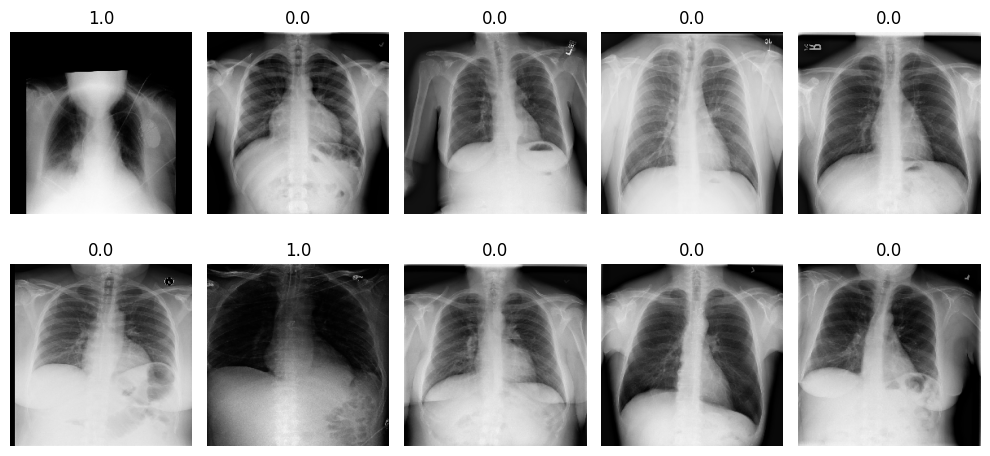

In [ ]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = next(test_gen)
plt.figure(figsize=(10, 5))
# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
print(test_gen.class_indices)
plt.tight_layout()
plt.show()

#MODELLO

In [ ]:
from tensorflow.keras.models import load_model

model_path = os.path.join(base_path, 'model/VGG16/Covid.h5')

model = load_model(model_path)

# Verifica la struttura del modello
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)                 │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,305,029 (58.38 MB)

 Trainable params: 590,339 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

#TEST PERFORMANCE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plotta una confusion matrix.
    :param y_true: Le etichette reali.
    :param y_pred: Le etichette predette dal modello.
    :param classes: Lista dei nomi delle classi.
    :param title: Titolo del grafico.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_roc_curve(model, X_test, y_test):
    """
    Plotta la curva ROC e calcola l'AUC (Area Under Curve).
    :param model: Il modello da testare.
    :param X_test: I dati di test.
    :param y_test: Le etichette reali del test set.
    """
    y_pred_prob = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


def classification_report_and_metrics(y_true, y_pred, target_names):
    """
    Stampa il report di classificazione (Precision, Recall, F1-Score) e calcola altre metriche utili.
    :param y_true: Le etichette reali.
    :param y_pred: Le etichette predette dal modello.
    :param target_names: Lista dei nomi delle classi.
    """
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)

    # Calcola precision, recall, f1-score per ciascuna classe
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {fscore:.2f}")
    return report


def evaluate_model(model, X_test, y_test, classes):
    """
    Esegue una valutazione completa del modello sui dati di test.
    :param model: Il modello da testare.
    :param X_test: I dati di test.
    :param y_test: Le etichette reali del test set.
    :param classes: Lista dei nomi delle classi.
    """
    # Previsioni
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, classes)

    # Classification Report & Metrics
    classification_report_and_metrics(y_test, y_pred, target_names=classes)

    # ROC Curve (solo per classificazione binaria)
    if len(classes) == 2:
        plot_roc_curve(model, X_test, y_test)


def evaluate_test_loss_accuracy(model, test_gen):
    # Esegue la valutazione del modello sul generatore di test
    test_loss, test_acc = model.evaluate(test_gen)

    # Stampa i risultati
    print(f"Loss sui dati di test: {test_loss}")
    print(f"Accuratezza sui dati di test: {test_acc}")


In [ ]:

# Estrai le etichette predette
#y_pred = np.argmax(pred, axis=1)

# Ottieni le etichette vere
y_test = test_gen.classes

# Ottieni i nomi delle classi
classes = list(test_gen.class_indices.keys())

# Esegui la valutazione completa del modello
evaluate_model(model, test_gen, y_test, classes)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/53 ━━━━━━━━━━━━━━━━━━━━ 21:41 25s/step

KeyboardInterrupt: 

In [ ]:
# Calcola e visualizza la perdita e l'accuratezza sui dati di test
evaluate_test_loss_accuracy(model, test_gen)

In [ ]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = next(test_gen)
plt.figure(figsize=(10, 5))
# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
print(test_gen.class_indices)
plt.tight_layout()
plt.show()

In [ ]:
# Genera le predizioni per il test set
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Converte le predizioni in classi binarie

# Ottieni le etichette vere dal generatore
y_true = test_gen.labels

# Trova gli errori
errors = np.where(y_pred_classes != y_true)[0]
print("Number of errors: ", len(errors))

# Trova le predizioni corrette
correct_predictions = np.where(y_pred_classes == y_true)[0]
print("Number of correct predictions: ", len(correct_predictions))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Seleziona solo 10 immagini classificate male
errors_10 = errors[:10]

# Visualizza 10 immagini classificate male con True Label e Predicted Label
plt.figure(figsize=(10, 5))

for i, idx in enumerate(errors_10):
    # Carica l'immagine originale
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))

    # Ottieni l'immagine come array
    img_array = image.img_to_array(img) / 255.0  # Normalizza l'immagine per la visualizzazione

    # Ottieni il true label e il predicted label
    true_label = y_true[idx]
    predicted_label = y_pred_classes[idx]

    # Visualizza l'immagine con titolo contenente true label e predicted label

    plt.subplot(2, 5, i + 1)  # 2 righe, 5 colonne
    plt.imshow(img_array)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#GRAD-CAM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


def get_conv_layer_names(model):
    """
    Extracts the names of all convolutional layers in the given Keras model.

    Parameters:
    model (tf.keras.Model): The pre-trained Keras model.

    Returns:
    list: A list of convolutional layer names.
    """
    conv_layers = []

    # Iterate through the layers in the model
    for layer in model.layers:
        # Check if the layer is a convolutional layer
        if 'conv' in layer.name:
            conv_layers.append(layer.name)

    return conv_layers

# Example usage:
# Assuming 'model' is your loaded Keras model
#conv_layer_names = get_conv_layer_names(model)
#print(conv_layer_names)


#conv_layers = get_conv_layer_names(model)
#print(conv_layers)

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Funzione per caricare e preprocessare un'immagine data la sua path.

    Args:
        img_path (str): Il percorso dell'immagine.
        target_size (tuple): La dimensione di destinazione per il ridimensionamento dell'immagine.

    Returns:
        img_array (numpy.ndarray): L'immagine preprocessata come input per la funzione make_gradcam_heatmap.
    """
    # Carica l'immagine dal percorso
    img = image.load_img(img_path, target_size=target_size)

    # Converti l'immagine in un array
    img_array = image.img_to_array(img)

    # Aggiungi una dimensione per rappresentare il batch
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocessa l'immagine (ad esempio per MobileNet, o sostituisci con la preprocessione appropriata)
    #img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    img_array = img_array / 255.0


    return img_array



def gradcam(img_path, model, conv_layers=None):
    """
    Applies Grad-CAM to visualize the regions of the image that contribute to the predictions
    for the specified convolutional layers.
    """

    # Preprocess the input image for Grad-CAM
    img_array = preprocess_image(img_path)
    full_heatmap = []

    if conv_layers is None:
        conv_layers = get_conv_layer_names(model)

    for layer in conv_layers:
        # Create a new model that outputs the activations of the convolutional layer and the final predictions
        new_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer).output, model.outputs])

        with tf.GradientTape() as tape:
            # Forward pass
            last_conv_layer_output, preds = new_model(img_array)
            preds = preds[0]

            # Get the predicted class index
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Compute the gradients of the class channel with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Pool the gradients across the width and height dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Compute the heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Debug: Verifica valori della heatmap
        print(f"Heatmap for layer {layer}: min = {np.min(heatmap)}, max = {np.max(heatmap)}")

        # Post-process the heatmap: remove negative values and normalize
        heatmap = np.maximum(heatmap, 0)  # ReLU to ensure only positive values
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize between 0 and 1

        full_heatmap.append(heatmap)

    # Load and preprocess the original image
    img_loaded = image.load_img(img_path, target_size=(224, 224))
    img = np.array(img_loaded)

    # Convert heatmaps to 8-bit format and apply the 'jet' colormap
    full_heatmap = [np.uint8(255 * heatmap) for heatmap in full_heatmap]
    jet = plt.colormaps.get_cmap("jet")  # Updated colormap function

    jet_heatmaps = []
    for heatmap in full_heatmap:
        # Apply the colormap to the heatmap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Convert to image format and resize to match the original image dimensions
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = np.array(jet_heatmap)
        jet_heatmaps.append(jet_heatmap)

    # Number of heatmaps to display
    num_heatmaps = len(jet_heatmaps)

    # Create a figure to display the original image, heatmaps, and superimposed image
    fig, axes = plt.subplots(1, num_heatmaps + 2, figsize=(5 * (num_heatmaps + 2), 6))

    # Display the original image
    axes[0].imshow(img.astype("uint8"))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the heatmaps
    for i in range(num_heatmaps):
        axes[i + 1].imshow(jet_heatmaps[i].astype("uint8"))
        axes[i + 1].set_title(f"Grad-CAM Heatmap {i+1}")
        axes[i + 1].axis('off')

    # Superimpose the last heatmap on the original image
    final_heatmap = jet_heatmaps[-1]
    superimposed_img = np.uint8(final_heatmap * 0.4 + img * 0.6)
    axes[num_heatmaps + 1].imshow(superimposed_img)
    axes[num_heatmaps + 1].set_title("Final Result")
    axes[num_heatmaps + 1].axis('off')

    plt.show()


Heatmap for layer block1_conv1: min = -0.0001368218509014696, max = 0.0001130218879552558
Heatmap for layer block1_conv2: min = -7.658683171030134e-05, max = 4.50047773483675e-05
Heatmap for layer block2_conv1: min = -0.00014853071479592472, max = 0.00011611868103500456
Heatmap for layer block2_conv2: min = -0.0002279310137964785, max = 9.041909652296454e-05
Heatmap for layer block3_conv1: min = -0.0006035596015863121, max = 0.0002015645441133529
Heatmap for layer block3_conv2: min = -0.0005399740766733885, max = 0.0002233456471003592
Heatmap for layer block3_conv3: min = -0.0005351915024220943, max = 0.00036026816815137863
Heatmap for layer block4_conv1: min = -0.001628291909582913, max = 0.0012026356998831034
Heatmap for layer block4_conv2: min = -0.0013520218199118972, max = 0.0011342543875798583
Heatmap for layer block4_conv3: min = -0.0008433065377175808, max = 0.001581959892064333
Heatmap for layer block5_conv1: min = -0.005761340260505676, max = 0.004175915848463774
Heatmap for 

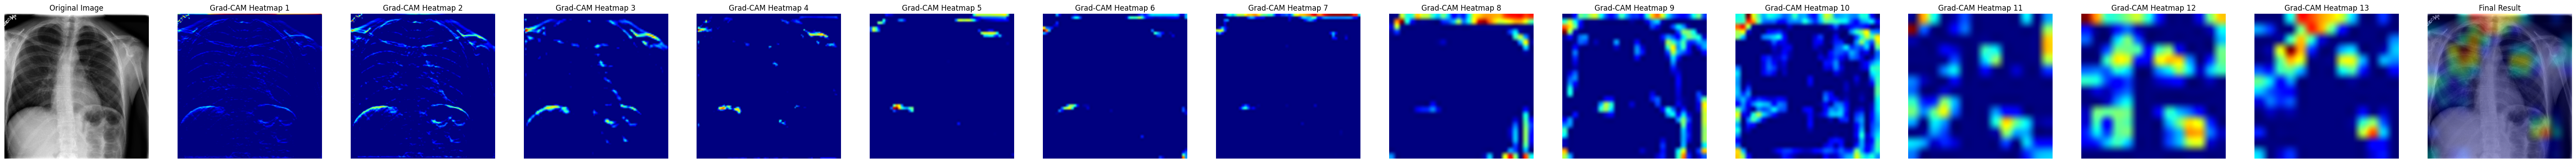

In [ ]:
gradcam(test_gen.filepaths[40],model)

In [ ]:
print(test_gen.filepaths[80], test_gen.labels[80])
print(test_gen)

#LIME

In [ ]:
!pip install tensorflow keras opencv-python matplotlib seaborn lime shap grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 39.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c83857fcc308375d1a05efa63828aadec2cb6064b0c00be2e3b08603cc8b5c57
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=0ff77f0a27d684d48836715ca83f3423fbc11892435f5671f4d493c2d0861946
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built lime grad-cam


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Funzione per applicare LIME su un'immagine
def lime(image, model, samples=500, features=5):
    explainer = lime_image.LimeImageExplainer()
    img = preprocess_image(image)

    # Esegui LIME
    explanation = explainer.explain_instance(img[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=samples)
    # Visualizzazione della spiegazione
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=features, hide_rest=False)


    # Visualizza l'immagine con i bordi del segmento evidenziati
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()
    return explanation



  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5

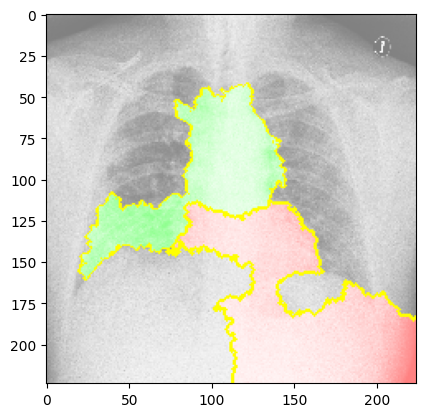

In [ ]:
# Applica LIME all'immagine
exp = lime(paths[0], model)

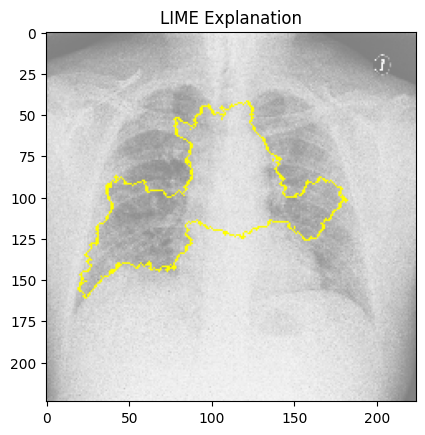

In [ ]:
temp, mask = exp.get_image_and_mask(
    exp.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualizza l'immagine con la maschera
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()

In [ ]:
# Ottieni l'importanza dei superpixel per la predizione
label = exp.top_labels[0]  # La label della classe predetta
importance_info = exp.local_exp[label]  # Local explanations per la classe

# Visualizza i superpixel con i rispettivi pesi
print("Superpixel e loro pesi (importanza):")
for superpixel, weight in importance_info:
    print(f"Superpixel {superpixel} ha un peso di {weight}")


Superpixel e loro pesi (importanza):
Superpixel 17 ha un peso di 0.005701583219051354
Superpixel 26 ha un peso di 0.005384464031897928
Superpixel 35 ha un peso di -0.00530336206756716
Superpixel 25 ha un peso di 0.004875409765751538
Superpixel 28 ha un peso di -0.004586168194078782
Superpixel 21 ha un peso di 0.004553429129959748
Superpixel 22 ha un peso di 0.003790047755603267
Superpixel 31 ha un peso di -0.003136201833400992
Superpixel 8 ha un peso di 0.003027233287931719
Superpixel 34 ha un peso di -0.003016057600948987
Superpixel 19 ha un peso di 0.0027060013617288656
Superpixel 12 ha un peso di 0.0026447971571038117
Superpixel 11 ha un peso di 0.002554731288073992
Superpixel 9 ha un peso di 0.0025155639202896775
Superpixel 0 ha un peso di -0.002470487842296091
Superpixel 30 ha un peso di 0.001902331410689329
Superpixel 10 ha un peso di 0.0018889131783902159
Superpixel 13 ha un peso di 0.0017885648222811371
Superpixel 27 ha un peso di -0.0016596175095750373
Superpixel 3 ha un peso 

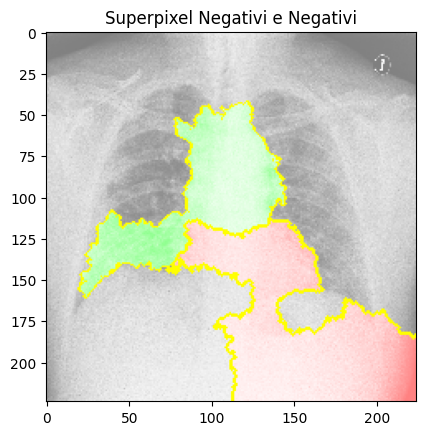

In [ ]:
# Visualizzazione: superpixel con contributo positivo e negativo
temp, mask = exp.get_image_and_mask(label, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("Superpixel Negativi e Negativi")
plt.show()


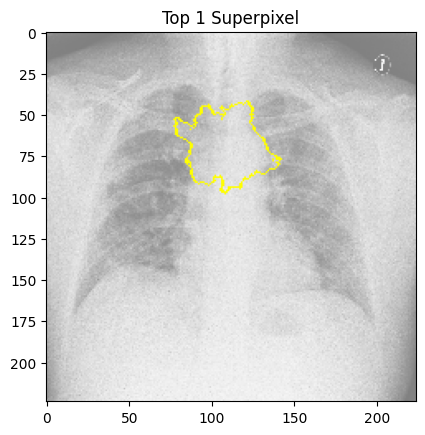

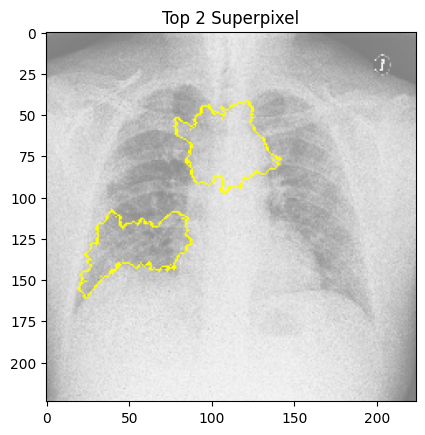

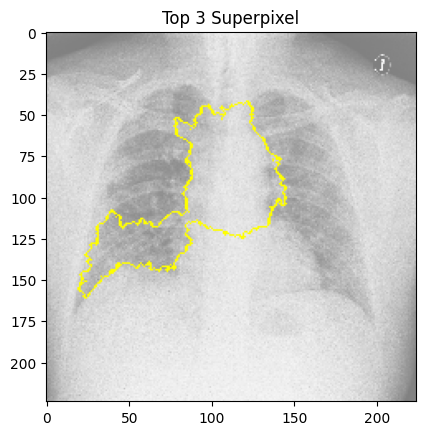

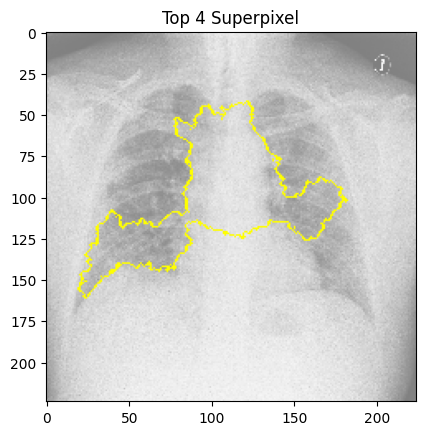

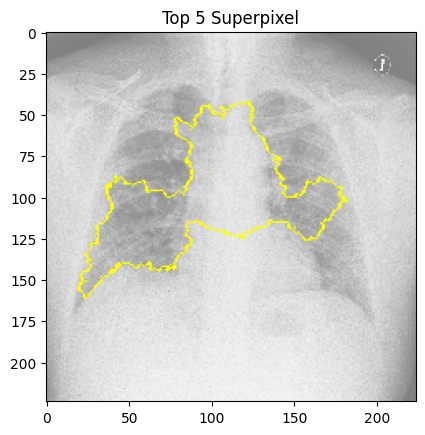

In [ ]:
# Itera attraverso i superpixel più rilevanti (basato su `features`)
for i in range(1, 5 + 1):
    temp, mask = exp.get_image_and_mask(label, positive_only=True, num_features=i, hide_rest=False)
    plt.figure()
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top {i} Superpixel")
    plt.show()


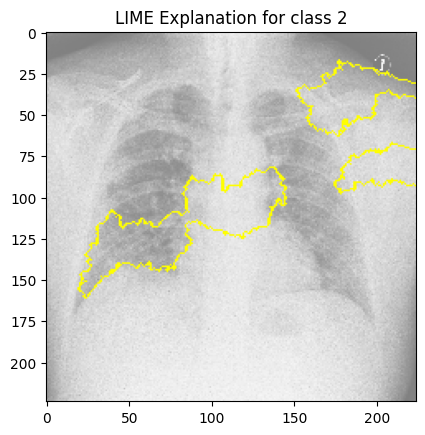

In [ ]:
# Visualizza tutte le maschere per ogni label predetta
for label in exp.top_labels:
    temp, mask = exp.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"LIME Explanation for class {label}")
    plt.show()


Heatmap for layer block1_conv1: min = -1.5786088169988943e-06, max = 3.4524471175245708e-06
Heatmap for layer block1_conv2: min = -1.3956341717857867e-06, max = 4.052216354466509e-06
Heatmap for layer block2_conv1: min = -7.948045094963163e-06, max = 9.130812941293698e-06
Heatmap for layer block2_conv2: min = -8.73142562340945e-06, max = 1.5053698007250205e-05
Heatmap for layer block3_conv1: min = -2.078773468383588e-05, max = 2.977012627525255e-05
Heatmap for layer block3_conv2: min = -2.4006345483940095e-05, max = 3.013998684764374e-05
Heatmap for layer block3_conv3: min = -2.8191796445753425e-05, max = 2.4329467123607174e-05
Heatmap for layer block4_conv1: min = -6.615150050492957e-05, max = 0.00010638845560606569
Heatmap for layer block4_conv2: min = -0.00017261304310522974, max = 3.3241547498619184e-05
Heatmap for layer block4_conv3: min = -6.635530735366046e-05, max = 0.00011300175538053736
Heatmap for layer block5_conv1: min = -0.00019899736798834056, max = 0.0002758927294053137

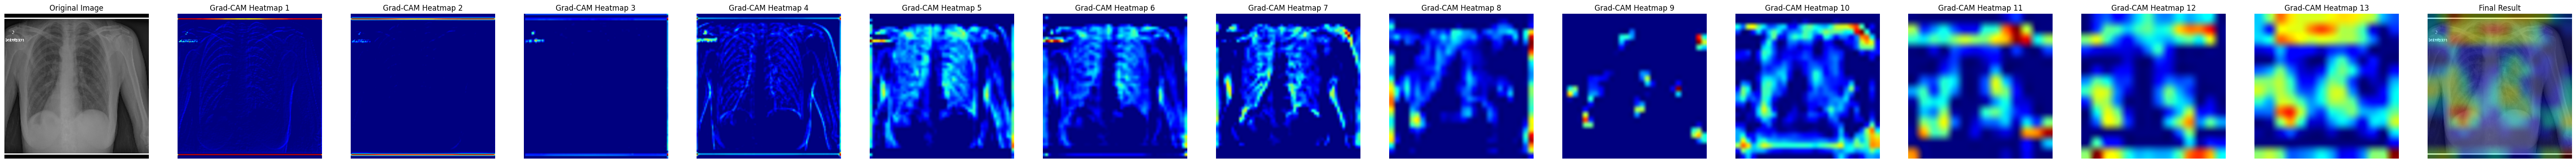

In [ ]:
gradcam(paths[11],model)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

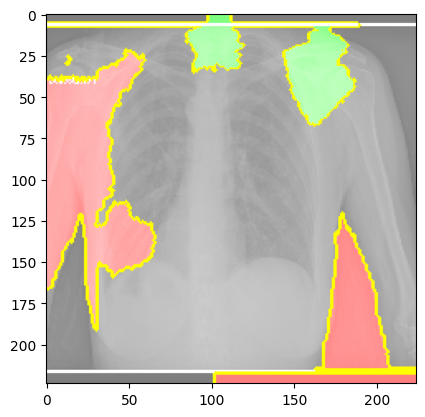

In [ ]:
exp2 = lime(paths[11],model,1000)

#SHAP

In [ ]:
!pip install shap
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.3 MB/s eta 0:00:00


In [ ]:
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import numpy as np
import matplotlib.pyplot as plt

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of ImageNet classes: 1000
Class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_const

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:02, 31.41s/it]


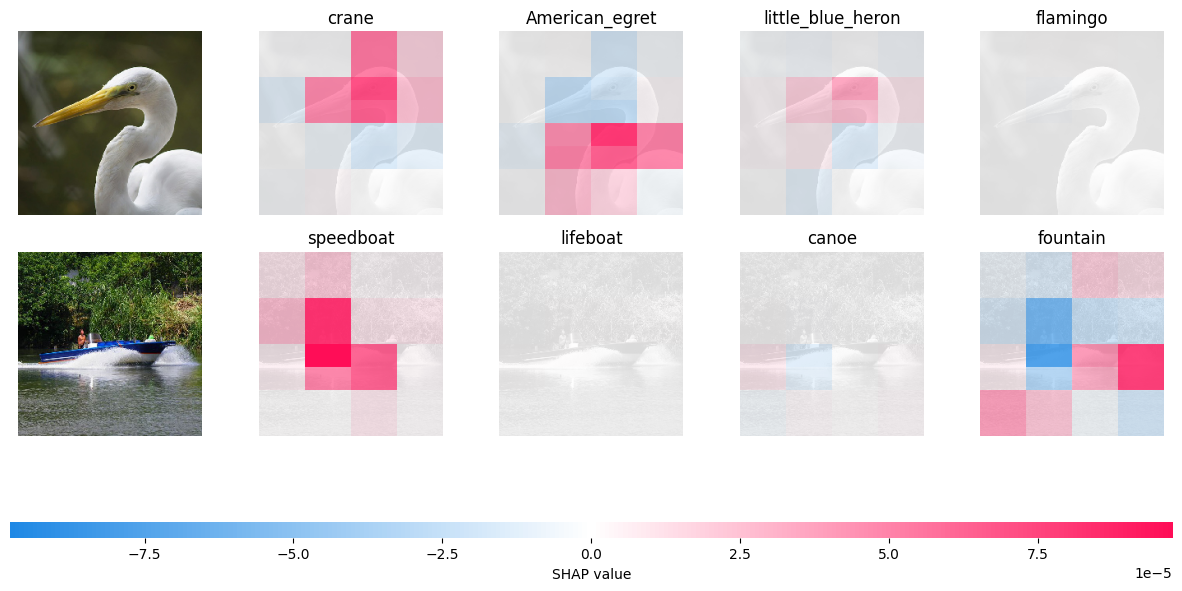

In [ ]:
# load pre-trained model and data
model = ResNet50(weights="imagenet")
X, y = shap.datasets.imagenet50()

# Assuming X[8] contains integer data that needs to be scaled to the range [0, 255]
X = np.clip(X, 0, 255).astype(np.uint8)

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

print("Number of ImageNet classes:", len(class_names))
print("Class names:", class_names)

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

# output with shap values
shap.image_plot(shap_values)

Image Path: /content/estrazione/dataset/CR.1.2.840.113564.1722810170.20200318082923328940.1003000225002.png, Label: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


PartitionExplainer explainer: 2it [01:23, 83.62s/it]               


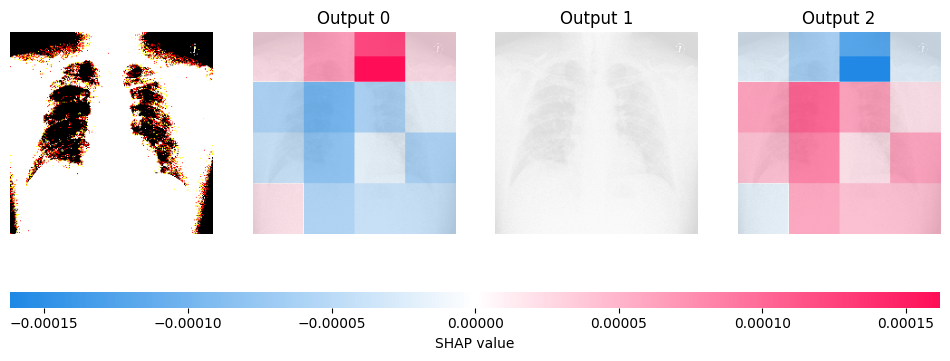

In [ ]:
import shap
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


# Funzione per caricare e preprocessare un'immagine
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

# Carica l'immagine dal primo percorso (X contiene i percorsi delle immagini)
img_path = paths[0]  # Il primo percorso di immagine
X = load_and_preprocess_image(img_path)

# Mostra le etichette corrispondenti (ad esempio, label[0])
y = labels[0]
print(f"Image Path: {img_path}, Label: {y}")

# Funzione di predizione
def f(x):
    return model.predict(x)

# Applica SHAP
# Definisci un masker che maschera le parti dell'immagine
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# Crea un explainer con il modello e il masker delle immagini
explainer = shap.Explainer(f, masker)

# Calcola i valori SHAP per l'immagine
shap_values = explainer(X, max_evals=100, batch_size=50)

# Visualizza i valori SHAP
def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min())

img_normalized = normalize_image(X)  # Normalizza l'immagine preprocessata
shap.image_plot(shap_values, img_normalized)


Image Path: /content/estrazione/dataset/CR.1.2.840.113564.1722810170.20200318082923328940.1003000225002.png, Label: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


PartitionExplainer explainer: 2it [01:18, 78.14s/it]               


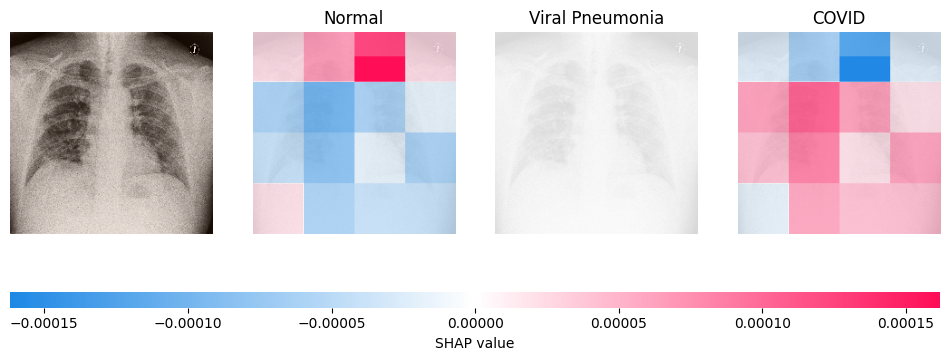

In [ ]:
import shap
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Funzione per caricare e preprocessare un'immagine
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

# Carica l'immagine dal primo percorso (X contiene i percorsi delle immagini)
img_path = paths[0]  # Il primo percorso di immagine
X = load_and_preprocess_image(img_path)

# Mostra le etichette corrispondenti (ad esempio, label[0])
y = labels[0]
print(f"Image Path: {img_path}, Label: {y}")

# Definisci i nomi delle classi
class_names = ["Normal", "Viral Pneumonia", "COVID"]

# Funzione di predizione
def f(x):
    return model.predict(x)

# Applica SHAP
# Definisci un masker che maschera le parti dell'immagine
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# Crea un explainer con il modello e il masker delle immagini
explainer = shap.Explainer(f, masker)

# Calcola i valori SHAP per l'immagine
shap_values = explainer(X, max_evals=100, batch_size=50)

# Visualizza i valori SHAP con le etichette
def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min())

img_normalized = normalize_image(X)  # Normalizza l'immagine preprocessata
shap.image_plot(shap_values, img_normalized, labels=class_names)